# Data

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets


In [ ]:
#  Mount the drive to load datasets
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [ ]:
# Import libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report,accuracy_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

### Synthetic data creation 

In [ ]:
# All the below steps create synthetic dataset for testing different anamoly detection models
syntetic_dataset = {}
syntetic_dataset['num'] = [[-1.1], [0.2], [101.1], [0.3], [1], [0.5]]
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
rng = np.random.RandomState(42)
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
syntetic_dataset['norm'] = make_blobs(centers=[[0, 0], [0, 0]],
                                      cluster_std=0.5,
                                      **blobs_params)[0]
syntetic_dataset['2cluster'] = make_blobs(centers=[[2, 2], [-2, -2]],
                                          cluster_std=[0.5, 0.5],
                                          **blobs_params)[0]
syntetic_dataset['2moon'] = 4. * (make_moons(n_samples=n_samples,
                                             noise=.05,
                                             random_state=0)[0] 
                                  - np.array([0.5, 0.25]))

for dataset in syntetic_dataset.keys():
    # Add outliers
    if dataset == 'num':
      continue
    syntetic_dataset[dataset] = np.concatenate([syntetic_dataset[dataset],
                                                rng.uniform(low=-6, high=6, 
                                                            size=(n_outliers, 2))],
                                                axis=0)

#### Plotting the Synthetic Data

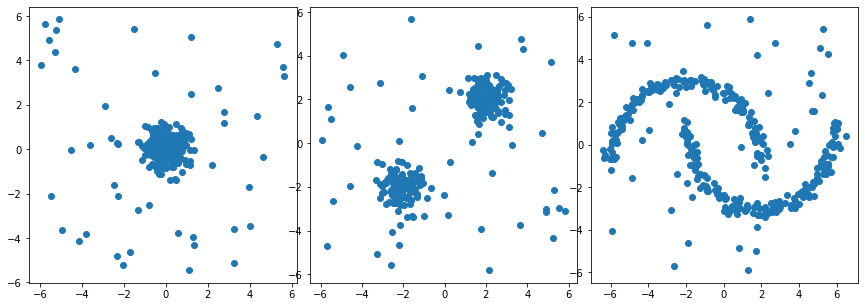

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)
plt.subplot(1, 3,1)
plt.scatter(syntetic_dataset['norm'][:,0],syntetic_dataset['norm'][:,1])
plt.subplot(1, 3,2)
plt.scatter(syntetic_dataset['2cluster'][:,0],syntetic_dataset['2cluster'][:,1])
plt.subplot(1, 3,3)
plt.scatter(syntetic_dataset['2moon'][:,0],syntetic_dataset['2moon'][:,1])
plt.show()

## KDD Cup 1999 Data
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between ''bad'' connections, called intrusions or attacks, and ''good'' normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on.

In [ ]:
from sklearn.datasets import fetch_kddcup99
dataset = fetch_kddcup99(shuffle=True,percent10=True)  # all the features or subset='http' for http features 
kdd99_x = dataset.data
kdd99_y = dataset.target
print('data shape:',kdd99_x.shape)
print('target shape:',kdd99_y.shape)

data shape: (494021, 41)
target shape: (494021,)


## Credit Card Fraud Detection
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

In [ ]:
# Load the credit card fraud dataset
creditcard_df = pd.read_csv('/drive/My Drive/anomaly_data/creditcard.csv')
print(creditcard_df.columns)
creditcard_df.fillna(0, inplace=True)


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


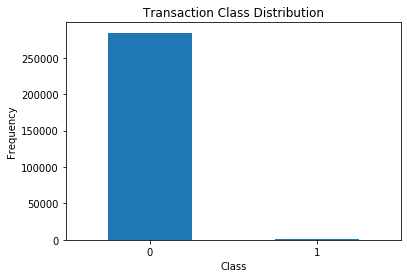

In [ ]:
# Distribution of fraud (anamoly) in the dataset
creditcard_Fraud = creditcard_df[creditcard_df['Class']==1]

creditcard_Normal = creditcard_df[creditcard_df['Class']==0]

outlier_fraction = len(creditcard_Fraud)/float(len(creditcard_Normal))

count_classes = pd.value_counts(creditcard_df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency");

In [ ]:
creditcard_df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

#### EDA - Fraud vs. Normal transactions

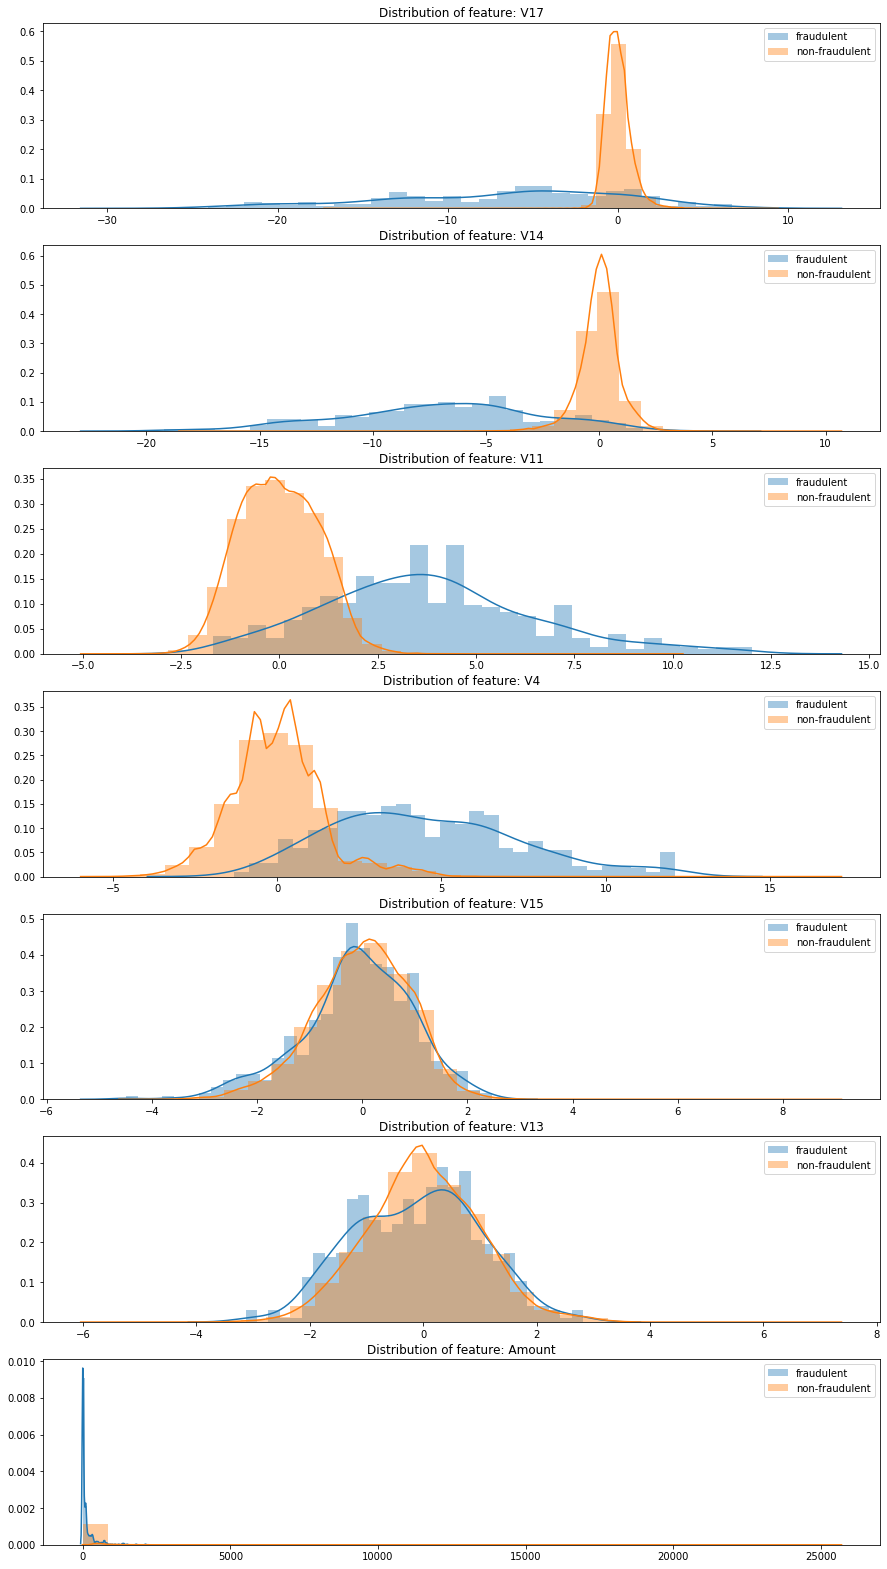

In [ ]:
features=['V17','V14', 'V11', 'V4', 'V15', 'V13','Amount']
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(creditcard_df[feat][creditcard_df.Class==1], bins=30)
    sns.distplot(creditcard_df[feat][creditcard_df.Class==0], bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

In [ ]:
# Filter the columns to remove data we do not want 
columns = [c for c in creditcard_df.columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
creditcard_X = creditcard_df[columns]
creditcard_Y = creditcard_df[target]
creditcard_X_outliers = state.uniform(low=0, high=1, size=(creditcard_X.shape[0], creditcard_X.shape[1]))
# Print the shapes of X & Y
print(creditcard_X.shape)
print(creditcard_Y.shape)
np.unique(np.array(creditcard_Y), return_counts=True)
# Scaling the data
scaler = MinMaxScaler()
creditcard_X_scaled = scaler.fit_transform(creditcard_X)

(284807, 30)
(284807,)


## MNIST

In [ ]:
# Load the MNIST dataset
mnist_df = pd.read_csv('/drive/My Drive/anomaly_data/mnist_train.csv', header=None)
anomalous_classes =[7]
contamination= 0.0005
mnist_df.describe()
mnist_data = mnist_df.values[:, 1:]
mnist_label = mnist_df.values[:, :1]
mnist_label = list(map(int, mnist_label))

classes, counts = np.unique(mnist_label, return_counts=True)
mnist_x = []
mnist_y = []
dropout_prob = contamination * (counts.sum() - counts[anomalous_classes].sum())
dropout_prob /= counts[anomalous_classes].sum() * (1 - contamination)
for i, (image, label) in enumerate(zip(mnist_data, mnist_label)):
    if label in anomalous_classes and random.random() >= dropout_prob:
        continue
    mnist_x.append(image),
    mnist_y.append(int(label in anomalous_classes))
mnist_x = np.array(mnist_x)
mnist_y = np.array(mnist_y)

scaler = MinMaxScaler()
mnist_x_scaled = scaler.fit_transform(mnist_x)

In [ ]:
np.unique(np.array(mnist_y), return_counts=True)

(array([0, 1]), array([53735,    35]))

#Some functions

###Performance evaluation 

In [ ]:
def find_best_threshold(y_true, y_pred_prob):
  best_f1_score = 0
  best_threshold = 0
  for threshold_val in np.arange(0.1, 0.95, 0.05):
      y_pred = y_pred_prob >= threshold_val
      f1_score = f1_score(y_true, y_pred)
      if best_f1_score < f1_score:
          best_threshold = threshold_val
          best_f1_score = f1_score
  return float(best_threshold)

In [ ]:
def eval(lab, pred):
  c = Counter()
  c.update(pred.round())
  print('prediction frequency: ')
  print(c)
  print(f"Accuracy Score: {accuracy_score(lab, pred.round())}")
  print(f"F1 Score: {f1_score(lab, pred.round())}")
  print(f"Average Precision Score: {average_precision_score(lab, pred.round())}")
  print(f"AUROC Score: {roc_auc_score(lab, pred)}")
  print(f"Confusion Matrix:\n {confusion_matrix(lab, pred.round())}")
  print("Classification Report :")
  print(classification_report(lab,pred.round()))

def eval_prob(lab, pred, threshold=0.5):
  c = Counter()
  c.update(pred>threshold)
  print('prediction frequency: ')
  print(c)
  print(f"Accuracy Score: {accuracy_score(lab, pred>threshold)}")
  print(f"F1 Score: {f1_score(lab, pred>threshold)}")
  print(f"Average Precision Score: {average_precision_score(lab, pred>threshold)}")
  print(f"AUROC Score: {roc_auc_score(lab, pred)}")
  print(f"Confusion Matrix:\n {confusion_matrix(lab, pred>threshold)}")
  print("Classification Report :")
  print(classification_report(lab,pred>threshold))

##### Visualization

In [ ]:
def visualization(X,p,threshold=0.5):
    plt.figure(figsize=(10,10))

    plt.scatter(X[:,0],X[:,1],c=p,cmap='viridis',marker='x')
    outliers = np.nonzero(p<threshold)[0]
    plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
    plt.colorbar();

# Isolation forest model - Unsupervised model (No labels required)


Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In [ ]:
# Creating a small sample data to understand the isolation ofrest model
X = np.array([[-1, -1], [-2, -1], [-3, -2], [0, 0], [-20, 50], [3, 5]])
clf = IsolationForest(n_estimators=2, warm_start=True)
clf.fit(X)  # fit 2 trees  
print(clf.predict(X))
print(clf.decision_function(X))

clf.set_params(n_estimators=20)  # adding more trees  
clf.fit(X)  # fit the added trees 
print(clf.predict(X))
print(clf.decision_function(X))


[ 1  1  1  1 -1  1]
[ 0.14097575  0.09193128  0.03618709  0.09193128 -0.27407126  0.03618709]
[ 1  1  1  1 -1 -1]
[ 0.13940534  0.13940534  0.05150146  0.08154412 -0.21682844 -0.04084681]


Above example clearly shows that isolation forest is able to detect the outlier points from the dataset. In the output predictions all the outliers are marked as -1. Also, decision_function() helps to find out the values of anamoly scores 

##Syntetic dataset

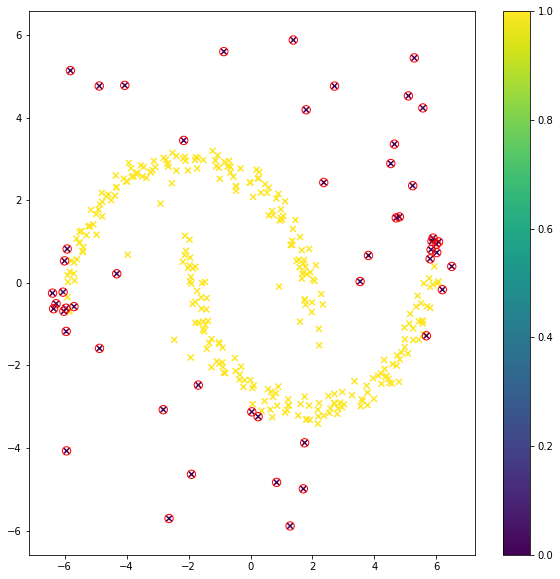

In [ ]:
syn_x = syntetic_dataset['2moon']

np.random.seed(1)
clf = IsolationForest(contamination=outliers_fraction)
preds = clf.fit_predict(syn_x)
des = clf.decision_function(syn_x)
visualization(syn_x,preds)
# visualization(syn_x,des>.01)

##Credit Card Fraud Dataset

In [ ]:
X = creditcard_X
Y = creditcard_Y

(array([-1,  1]), array([   493, 284314]))


###Exercise 1
Train a model using isolation forest and test different hyper-parameter to get the best result. you can find the list of all hyper parameters here: [*IsolationForest*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

Challenge : Report your best F1-score on slack! Let’s see who got the best score!!

y_pred: output prediction


In [ ]:
print(np.unique(np.array(y_pred), return_counts=True))
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [ ]:
eval(Y,y_pred)

prediction frequency: 
Counter({0: 284314, 1: 493})
Accuracy Score: 0.9976018847851352
F1 Score: 0.30659898477157355
Average Precision Score: 0.09520033638343485
AUROC Score: 0.6528538389731189
Confusion Matrix:
 [[283973    342]
 [   341    151]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.31      0.31      0.31       492

    accuracy                           1.00    284807
   macro avg       0.65      0.65      0.65    284807
weighted avg       1.00      1.00      1.00    284807



#One-SVM

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as One-Class SVM.

## Synthetic datasets

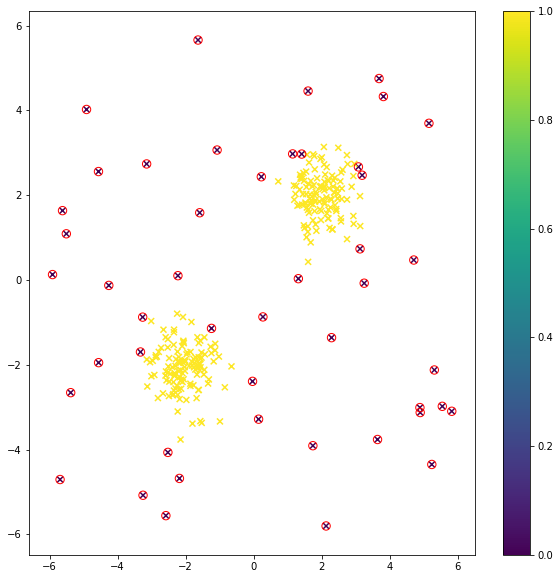

In [ ]:
syn_x = syntetic_dataset['2cluster']
m = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
preds = m.fit_predict(syn_x)
score = m.score_samples(syn_x)
# visualization(syn_x,score,8.6)
visualization(syn_x,preds)

## Credit Card Fraud Dataset

In [ ]:
X=creditcard_X_scaled[:20000,:]
Y=creditcard_Y[:20000]



###Exercise 2
Train a model using OneClassSVM and test different hyper-parameter to get the best result. you can find the list of all hyper parameters here: [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM)

Challenge : Report your best F1-score on slack! Let’s see who got the best score!!

y_pred: output prediction


In [ ]:
print(np.unique(np.array(y_pred), return_counts=True))
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [ ]:
eval(Y,y_pred)

#Clustering

##K-means

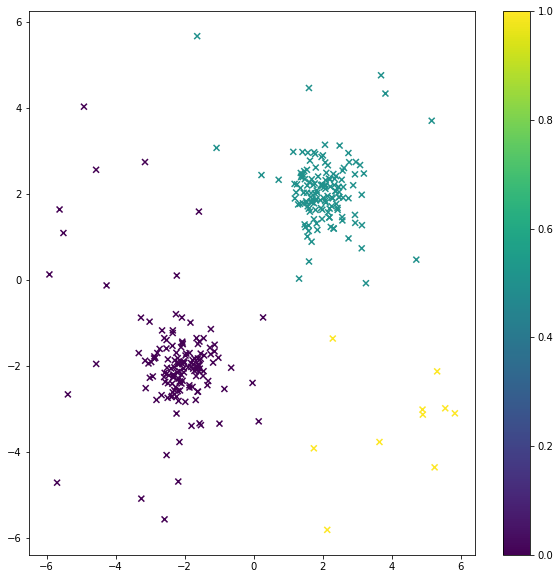

In [ ]:
syn_x = syntetic_dataset['2cluster']
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(syn_x)
centers = kmeans.cluster_centers_
preds = kmeans.predict(syn_x)
preds
visualization(syn_x,preds,0)

[[-2.22648668 -1.93260421]
 [ 2.01502511  2.08097068]
 [ 4.15310012 -3.35078973]]


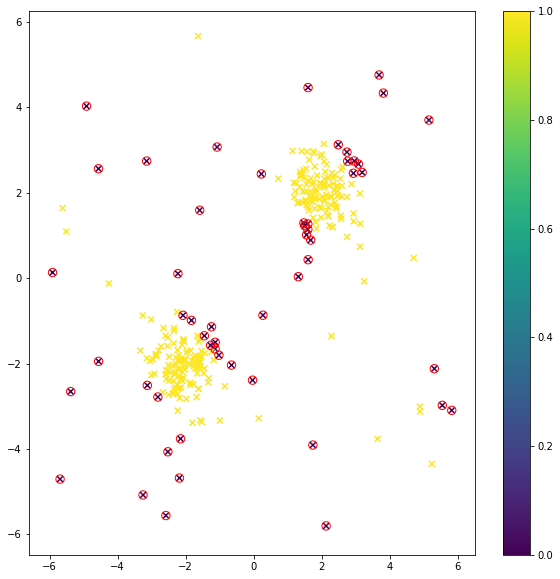

In [ ]:
# All the points that are farther than the formed clusters are treated as anamolies
np.unique(preds)
clusters = kmeans.cluster_centers_[preds]
print(kmeans.cluster_centers_)
dist = np.average([np.sum(c1 - c2)**2 for c1, c2 in zip(syn_x, clusters)])
dist_all = np.array([float(np.sum(c1 - c2)**2<dist) for c1, c2 in zip(syn_x, clusters)])
visualization(syn_x,dist_all)

In [ ]:
print(dist)
print(np.unique(np.array(dist_all), return_counts=True))

1.443490999651389
(array([0., 1.]), array([ 53, 247]))


##DBSCAN

DBSCAN will output an array of -1’s and 0’s, where -1 indicates an outlier. Below, I visualize outputted outliers in red by plotting two variables.

More info: https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818

##synthetic dataset 

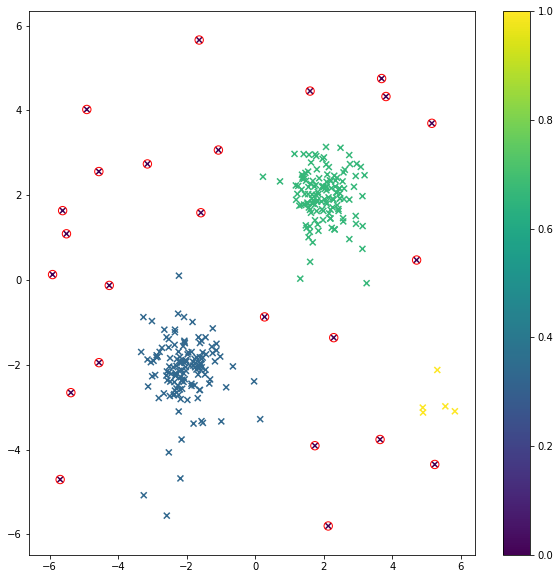

In [ ]:
m = DBSCAN(min_samples = 3, eps = 1)

clusters = m.fit_predict(syntetic_dataset['2cluster'])
list(clusters).count(-1)

visualization(syntetic_dataset['2cluster'],clusters,0)


In [ ]:
clusters

array([ 0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  1,  1,  0,  0,  1,
        1,  1,  0,  0,  1,  1,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  1,
        1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,
        1,  1,  0,  1,  1,  1,  1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  1,  1,  0,  1,  0,
        0,  0,  1,  1,  1,  1,  0,  1,  0,  0,  0,  0,  1,  0,  1,  1,  0,
        0,  0,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  1,  1,  0,  1,  1,
        0,  0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,
        1,  1,  1,  1,  1,  0,  0,  0,  0,  1,  1,  1,  0,  1,  0,  1,  1,
        0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,
        1,  0,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  0,  1,  1,  0,  0,
        0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  1,  1,  1,  0,  1,  0,
        0,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  0,  1,  1,  0,  1,
        0,  1,  0,  1,  0

##Credit Card Fraud Dataset

In [ ]:
X=creditcard_X_scaled[:20000,:]
Y=creditcard_Y[:20000]


###Exercise 3
Train a model using DBSCAN and test different hyper-parameter to get the best result. you can find the list of all hyper parameters here: [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)

Challenge : Report your best F1-score on slack! Let’s see who got the best score!!

y_pred: output prediction


In [ ]:
print(np.unique(np.array(clusters), return_counts=True))
clusters[clusters != -1] = 0
clusters[clusters == -1] = 1

In [ ]:
eval(Y,clusters)

prediction frequency: 
Counter({0: 7505, 1: 2495})
Accuracy Score: 0.7543
F1 Score: 0.030003947887879984
Average Precision Score: 0.015230460921843688
AUROC Score: 0.8766813892792612
Confusion Matrix:
 [[7505 2457]
 [   0   38]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9962
           1       0.02      1.00      0.03        38

    accuracy                           0.75     10000
   macro avg       0.51      0.88      0.44     10000
weighted avg       1.00      0.75      0.86     10000



#Shuffling 

##Credit Card Fraud Dataset

In [ ]:
X = creditcard_X_scaled
Y = creditcard_Y
X_pure=[X[i] for i in range(len(X)) if Y[i]==0]
Y_pure=[Y[i] for i in range(len(Y)) if Y[i]==0]

X1 = np.array(X_pure)
X2 = np.array(X_pure)
X2 = X2.T
for i in range(len(X2)):
    np.random.shuffle(X2[i])
X2 = X2.T
print(X1.shape, X2.shape)

(284315, 30) (284315, 30)


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(64,),max_iter=20)
X_all = np.concatenate((X1, X2))
Y_all = Y_pure + [1]*len(X2)
clf.fit(X_all, Y_all)

pred_all = clf.predict(X_all)
eval(Y_all, pred_all)

pred_val = clf.predict(X)
eval(Y, pred_val)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


prediction frequency: 
Counter({0: 321630, 1: 247000})
Accuracy Score: 0.7551430631517859
F1 Score: 0.7379464159679286
Average Precision Score: 0.7025040536167582
AUROC Score: 0.7551430631517858
Confusion Matrix:
 [[233356  50959]
 [ 88274 196041]]
Classification Report :
              precision    recall  f1-score   support

           0       0.73      0.82      0.77    284315
           1       0.79      0.69      0.74    284315

    accuracy                           0.76    568630
   macro avg       0.76      0.76      0.75    568630
weighted avg       0.76      0.76      0.75    568630

prediction frequency: 
Counter({0: 233604, 1: 51203})
Accuracy Score: 0.8202045595789429
F1 Score: 0.009439984524615534
Average Precision Score: 0.003234066680570757
AUROC Score: 0.6583503296827105
Confusion Matrix:
 [[233356  50959]
 [   248    244]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    284315
           1   

In [ ]:
pred_val = clf.predict_proba(X)[:,1]
eval_prob(Y, pred_val,0.95)

prediction frequency: 
Counter({False: 284434, True: 373})
Accuracy Score: 0.9980372673424459
F1 Score: 0.353757225433526
Average Precision Score: 0.12874863976729556
AUROC Score: 0.6081825680293629
Confusion Matrix:
 [[284095    220]
 [   339    153]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.41      0.31      0.35       492

    accuracy                           1.00    284807
   macro avg       0.70      0.66      0.68    284807
weighted avg       1.00      1.00      1.00    284807



###Exercise 4
Shuffle each coloumn individually and train a model based on it and then combine then(ensemble) to do the prediction!

#Exercise 5
Test these models on MNIST, KDD cup dataset and report you best score! :-)